In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from factor_analyzer import FactorAnalyzer
from models import Autoencoder
from sklearn.decomposition import NMF
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from utils import translate_text

# Main 

## preparing the data

In [2]:
code_dir = Path(os.getcwd())
data_path = code_dir.parent / "data"
assert os.path.exists(
    data_path
), "Data directory not found. Make sure you're running this code from the root directory of the project."

with open(data_path / "cbcl_data_remove_unrelated.csv", "r", encoding="utf-8") as f:
    qns = pd.read_csv(f)

X = qns.iloc[:, 2:].values

# Standardize the data
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and validation sets
X_train_raw, X_temp = train_test_split(X, test_size=0.4)
X_val_raw, X_test_raw = train_test_split(X_temp, test_size=0.5)


X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

## Train and save the model

Early stopping at epoch 76


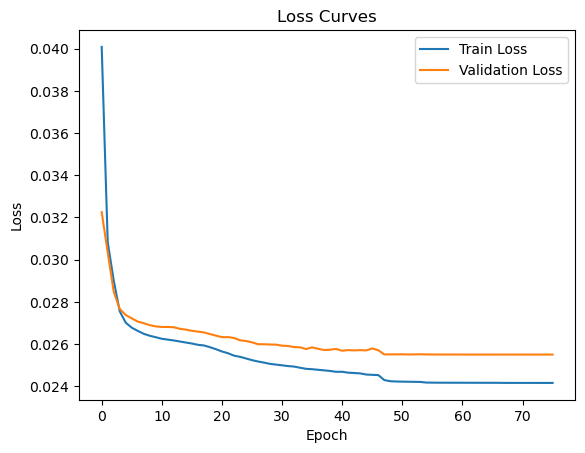

Explained variance ratio of latent factor 1: 0.04108941
Explained variance ratio of latent factor 2: 0.03338297
Explained variance ratio of latent factor 3: 0.05120108
Explained variance ratio of latent factor 4: 0.03460398
Explained variance ratio of latent factor 5: 0.05293032
Total explained variance ratio (by all factors): 0.39251087


In [3]:
autoencoder = Autoencoder(X_train, X_val, encoding_dim=5)
autoencoder.train()
(
    latent_factors,
    reconstruction_errors_test,
    explained_variance_ratios,
    explained_variance_ratio_test,
) = autoencoder.evaluate_on_data(X_scaled)

In [ ]:
autoencoder.export_to_onnx(X_train, onnx_path = "../output/autoencoder_real_input.onnx")  # export model

Model exported to ../output/autoencoder_real_input.onnx
Serving '../output/autoencoder_real_input.onnx' at http://localhost:8080


In [6]:
latent_factors = latent_factors  # convert to NumPy
X_scaled = np.array(X_scaled)  # convert to NumPy

# calculate loadings
loadings = []
for i in range(X_scaled.shape[1]):  # transversal all features
    reg = LinearRegression().fit(latent_factors, X_scaled[:, i])  # regression
    loadings.append(reg.coef_)  # store the coefficients

loading_matrix = np.array(
    loadings
).T  #  transpose to (latent factors, original features)

print("Loading matrix shape:", loading_matrix.shape)

Loading matrix shape: (5, 113)


## Explore the possible dimensions of the hidden layer

dim: 4
Early stopping at epoch 83


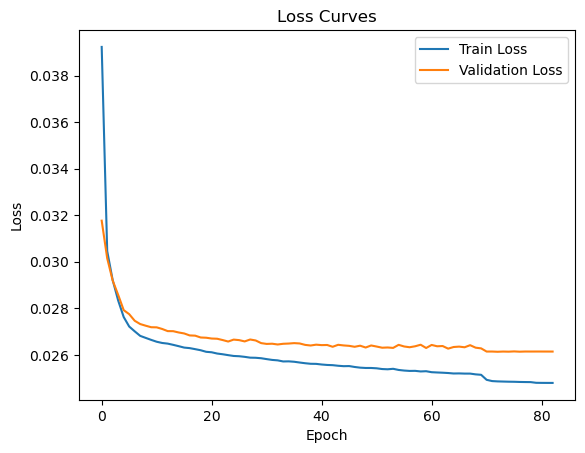

Explained variance ratio of latent factor 1: 0.04801101
Explained variance ratio of latent factor 2: 0.05386412
Explained variance ratio of latent factor 3: 0.07357478
Explained variance ratio of latent factor 4: 0.06737465
Total explained variance ratio (by all factors): 0.37472939
dim: 5


C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_2608\3577538529.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dim_df = pd.concat([dim_df, temp_df], ignore_index=True)


Early stopping at epoch 158


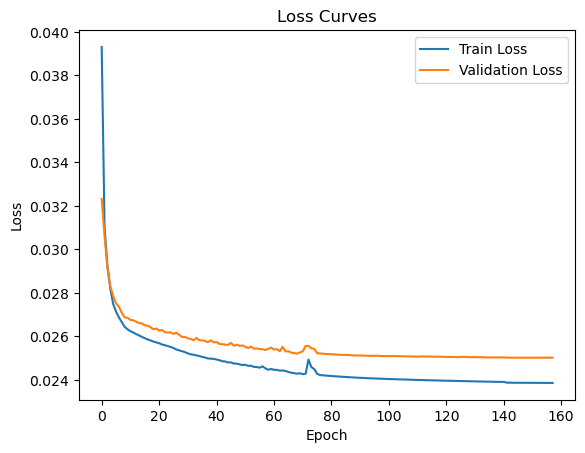

Explained variance ratio of latent factor 1: 0.05340465
Explained variance ratio of latent factor 2: 0.06863111
Explained variance ratio of latent factor 3: 0.09188276
Explained variance ratio of latent factor 4: 0.05476680
Explained variance ratio of latent factor 5: 0.04583757
Total explained variance ratio (by all factors): 0.40137903
  dim  Factor_1  Factor_2  Factor_3  Factor_4  Factor_5 Factor_6 Factor_7  \
0   4  0.048011  0.053864  0.073575  0.067375       NaN     None     None   
1   5  0.053405  0.068631  0.091883  0.054767  0.045838     None     None   

  Factor_8 Factor_9 Factor_10  Total variance ratio  
0     None     None      None              0.374729  
1     None     None      None              0.401379  


C:\Users\Makka Papa\AppData\Local\Temp\ipykernel_2608\3577538529.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dim_df = pd.concat([dim_df, temp_df], ignore_index=True)


In [7]:
# Initialize the DataFrame to store the results
dim_df = pd.DataFrame(
    columns=["dim"] + [f"Factor_{i+1}" for i in range(10)] + ["Total variance ratio"]
)

for latent_dim in range(4, 6):
    print("dim:", latent_dim)

    # Initialize and train the autoencoder
    autoencoder = Autoencoder(X_train, X_val, encoding_dim=latent_dim)
    autoencoder.train()

    # Evaluate the autoencoder on the scaled data
    (
        latent_factors,
        reconstruction_errors,
        explained_variance_ratios,
        explained_variance_ratio_total,
    ) = autoencoder.evaluate_on_data(X_scaled)

    # Create a temporary DataFrame to store the results for the current latent dimension
    temp_df = pd.DataFrame(
        {
            "dim": [latent_dim],  # Current dimension
            **{
                f"Factor_{i+1}": ratio
                for i, ratio in enumerate(explained_variance_ratios)
            },
            "Total variance ratio": [explained_variance_ratio_total],
        }
    )

    # Fill missing factor columns with NaN to maintain consistent column names
    for col in dim_df.columns:
        if col not in temp_df.columns:
            temp_df[col] = None  # Fill with NaN

    # Sort columns to match the order in dim_df
    temp_df = temp_df[dim_df.columns]

    # Concatenate the temporary DataFrame with the main DataFrame
    dim_df = pd.concat([dim_df, temp_df], ignore_index=True)

print(dim_df)

## NMF

In [8]:
data_cleaned = qns.iloc[:, 2:]  # the cbcl data

rank = 5  # number of components to extract

# NMF dicomposition
nmf_model = NMF(
    n_components=rank, init="random", solver="mu", max_iter=1000, random_state=42
)
W = nmf_model.fit_transform(data_cleaned)  # 基矩阵 W basis matrix
H = nmf_model.components_  # 系数矩阵 H coefficients matrix

# reconstruction error
reconstruction_error = nmf_model.reconstruction_err_
print(f"Reconstruction error: {reconstruction_error}")

# reconstruct the matrix
X_reconstructed = np.dot(W, H)

# calculate Frobenius norm
X_norm = np.linalg.norm(data_cleaned, ord="fro")
reconstruction_error_frobenius = np.linalg.norm(
    data_cleaned - X_reconstructed, ord="fro"
)

# calculate relative error
relative_error = reconstruction_error_frobenius / X_norm
print(f"Relative Error: {relative_error}")

# calculate explained variance
data_cleaned_np = data_cleaned.to_numpy()

# calculate the total variance of the original data matrix
total_variance = np.sum((data_cleaned_np - np.mean(data_cleaned_np)) ** 2)

# calculate the variance of the reconstructed matrix
reconstructed_variance = np.sum((X_reconstructed - np.mean(X_reconstructed)) ** 2)

# variance_explained
variance_explained = reconstructed_variance / total_variance
print(f"Variance explained by the NMF model: {variance_explained * 100:.2f}%")

# add ID to W
W_with_id = pd.concat([pd.Series(qns.iloc[:, 1], name="ID"), pd.DataFrame(W)], axis=1)

# 转置 H
H_transposed = H.T

Reconstruction error: 370.2656381688937
Relative Error: 0.7211395091258631
Variance explained by the NMF model: 38.42%


## Interpretability

### results from autoencoder

In [9]:
# 将 latent_df 转换为 numpy 数组（如果它是 Pandas DataFrame）
latent_factors = (
    latent_factors.values
    if isinstance(latent_factors, pd.DataFrame)
    else latent_factors
)
original_features = X if isinstance(X, np.ndarray) else X.values

# 存储每个原始特征的回归系数
n_original_features = original_features.shape[1]
n_latent_factors = latent_factors.shape[1]

loadings = []

# 对每个原始特征进行回归，使用 latent_factors 作为输入特征
for i in range(n_original_features):
    y = original_features[:, i]  # 当前原始特征
    reg = LinearRegression().fit(latent_factors, y)
    loadings.append(reg.coef_)

# 将结果转换为 DataFrame，便于查看
loadings_df = pd.DataFrame(
    loadings, columns=[f"Latent_{j+1}" for j in range(n_latent_factors)]
)
loadings_df.index = [f"Feature_{i+1}" for i in range(n_original_features)]

# 输出每个潜在因子对原始特征的贡献（类似于 PCA 的负载）the loading matrix of the autoencoder
print(loadings_df)

             Latent_1  Latent_2  Latent_3  Latent_4  Latent_5
Feature_1    0.224589  0.711329 -0.462325  0.262245  0.095681
Feature_2   -0.429509  0.212378 -0.406328 -0.121743  0.246847
Feature_3   -0.099233  0.079144 -0.125884  0.129792  0.083246
Feature_4   -0.017850  0.012580 -0.019286  0.007119  0.011392
Feature_5    0.058611  0.263695 -0.260206  0.045461 -0.019877
...               ...       ...       ...       ...       ...
Feature_109 -0.066821  0.038090 -0.062806 -0.015049 -0.022269
Feature_110  0.079378  0.354045 -0.256495  0.195729  0.262773
Feature_111 -0.009974  0.000414 -0.004116  0.008144  0.005829
Feature_112 -0.121872 -0.001666 -0.099674  0.140258  0.097772
Feature_113  0.076167  0.198453 -0.140786  0.248224  0.728387

[113 rows x 5 columns]


In [10]:
loadings_df.index = qns.iloc[:, 2:].columns
df = pd.DataFrame()
for i in range(latent_dim):
    df0 = (
        loadings_df["Latent_{0}".format(i + 1)]
        .reindex(
            loadings_df["Latent_{0}".format(i + 1)]
            .abs()
            .sort_values(ascending=False)
            .index
        )
        .to_frame(name="Latent_{0}".format(i + 1))
    )
    df0 = df0.reset_index().rename(columns={"index": "Row_Name"})
    df = pd.concat([df, df0], axis=1)
df_even_columns = df.iloc[
    :, ::2
]  # # Select all rows and every second column from the DataFrame

details_autoencoder = translate_text(df_even_columns, 5, "en")
details_autoencoder

,Factor 0 Detail,Factor 0 Translated_Detail,Factor 1 Detail,Factor 1 Translated_Detail,Factor 2 Detail,Factor 2 Translated_Detail,Factor 3 Detail,Factor 3 Translated_Detail,Factor 4 Detail,Factor 4 Translated_Detail
0,Inattentive or easily distracted No presta ate...,Inattentive or easily distracted does not pay ...,Argues a lot Discute mucho,Argues to Lot discusses a lot,Bites fingernails Se come/muerde las uñas,Bites fingernails eats/bite the nails,Self-conscious or easily embarrassed Se cohíbe...,Self-Conscious or Easily Geldssed is cohifted ...,Worries Se preocupa mucho,Worries worries a lot
1,"Can't concentrate, can't pay attention for lon...","Can't concentrate, Can't pay attention for lon...",Bites fingernails Se come/muerde las uñas,Bites fingernails eats/bite the nails,Inattentive or easily distracted No presta ate...,Inattentive or easily distracted does not pay ...,"Can't concentrate, can't pay attention for lon...","Can't concentrate, Can't pay attention for lon...",Too fearful or anxious Demasiado ansioso(a) o ...,Too Fearful or Anxious too anxious (a) or fear...
2,Bites fingernails Se come/muerde las uñas,Bites fingernails eats/bite the nails,Disobedient at home Desobedece en casa,Disobedient at home disobey at home,Argues a lot Discute mucho,Argues to Lot discusses a lot,"Can't sit still, restless, or hyperactive No p...","Can't Sit Still, Restless, or Hyperactive cann...","Nervous, highstrung, or tense Nervioso(a), ten...","Nervous, highstrung, or tense nervous (a), ten..."
3,Fails to finish things they start,FAILS TO FINISH THINGS THE START,Temper tantrums or hot temper Le dan rabietas ...,Tem Tentrums or Hot Tem,"Can't concentrate, can't pay attention for lon...","Can't concentrate, Can't pay attention for lon...",Inattentive or easily distracted No presta ate...,Inattentive or easily distracted does not pay ...,Feels they have to be perfect,Feels they have to be perfect
4,Daydreams or gets lost in their thoughts,Daydreams or Gets Lost in Their Thoughts,"Stubborn, sullen, or irritable Obstinado(a), m...","Stubborn, Sullen, Orritable stubborn (A), Malh...",Fails to finish things they start,FAILS TO FINISH THINGS THE START,Too shy or timid Demasiado tímido(a),Too Shy or Timid too shy (a),Self-conscious or easily embarrassed Se cohíbe...,Self-Conscious or Easily Geldssed is cohifted ...
...,...,...,...,...,...,...,...,...,...,...
108,"Sulks a lot Queda contrariado(a), pone mala ca...","Sulks A Lot is counterclocking (a), it frequen...",Problems with eyes (not if corrected by glasse...,Problems with Eyes (not if correct by Glasses)...,Wets self during the day Se orina en la ropa d...,Wets Self During the Day urinates in clothes d...,Plays with own sex parts in public Se toca/jue...,Plays with Own Sex Parts in public is played/p...,Wishes to be of opposite sex Desea ser del sex...,Wishes to be of opposite sex wants to be of th...
109,Other (physical problems without known physica...,Other,Sleeps more than most kids during day and/or n...,Sleeps More than Most Kids During Day and/Or N...,Thumb-sucking Se chupa el dedo,Thumb-Sucking sucks your finger,"Gets hurt a lot, accident prone Se lastima acc...","Gets Hurt a Lot, accidentally hurts very frequ...",Overeating Come demasiado,Overeating eat too much
110,Sudden changes in mood or feelings Súbitos cam...,Sudden changes in mood or sudden feelings humo...,"Withdrawn, doesn't get involved with others Se...","Withdrawn, Doesn't Get Involved with Others is...",Plays with own sex parts in public Se toca/jue...,Plays with Own Sex Parts in public is played/p...,Disobedient at school Desobedece en la escuela,Disobedient at School disobeys at school,Runs away from home Se fuga de la casa,Runs Away from Home escapes the house
111,Talks or walks in sleep Habla o camina cuando ...,TALKS OR WALKS IN SLEEP Talk or WALK WHEN IT I...,Wishes to be of opposite sex Desea ser del sex...,Wishes to be of opposite sex wants to be of th...,Sets fires Prende fuegos/inicia incendios,Sets Fire

### results from NMF

In [ ]:
label = pd.read_csv(
    r"G:\ABCD\script\trail\trail_tsne_RF\factor analysis\output\NA\NMF_H.csv"
).iloc[:, 1:]
label.index = qns.iloc[:, 2:].columns
df_NMF = pd.DataFrame()
for i in range(5):
    df0 = (
        label["V{0}".format(i + 1)]
        .reindex(label["V{0}".format(i + 1)].abs().sort_values(ascending=False).index)
        .to_frame(name="V{0}".format(i + 1))
    )
    df0 = df0.reset_index().rename(columns={"index": "Row_Name{0}".format(i + 1)})
    df_NMF = pd.concat([df_NMF, df0], axis=1)
df_NMF_even_columns = df_NMF.iloc[:, ::2]  # 选择所有行和每隔两列的列

details = translate_text(df_NMF_even_columns, 5, "en")
details

### EFA

In [ ]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=5, rotation="varimax")
fa.fit(X_scaled)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev
factor_loadings = fa.loadings_
# 计算每个因子的贡献方差和方差解释率
variance_explained = fa.get_factor_variance()
print(f"varience explained: {variance_explained[2][-1]:.2%}")

# 计算所有个体的因子得分
factor_scores = fa.transform(X_scaled)
factor_scores.shape

varience explained: 24.05%


## Draw the reconstuction error of the autoencoder model

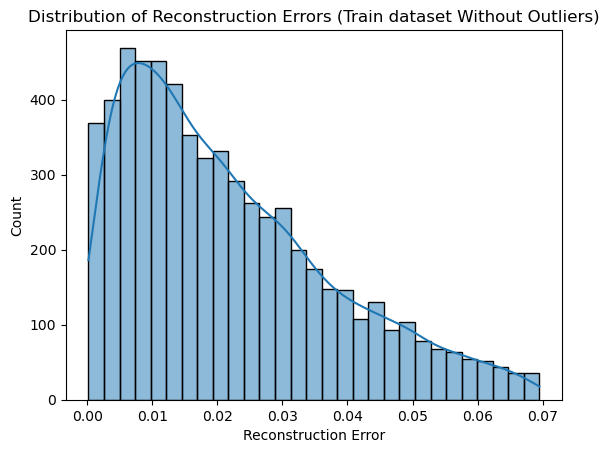

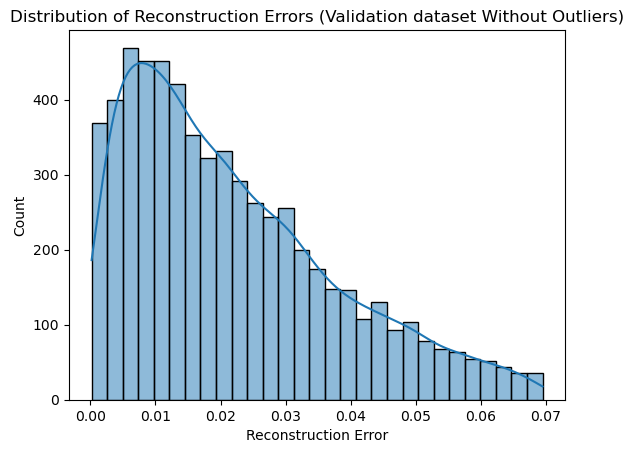

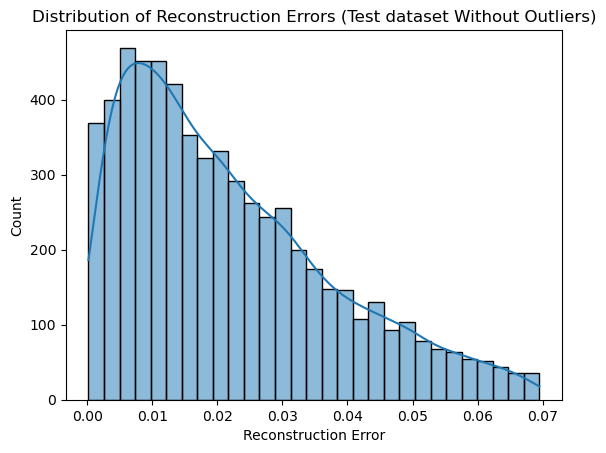

In [ ]:
import matplotlib.pyplot as plt

# Define the datasets
datasets = {"Train": X_train, "Validation": X_val, "Test": X_test}

# Plot the reconstruction errors
autoencoder.plot_reconstruction_errors(datasets)

## Lasso regression model from questionnaire items to factors generated with NMF (from Toby)

100%|██████████| 13/13 [00:22<00:00,  1.73s/it]
g:\ABCD\script\trail\trail_tsne_RF\factor analysis\Autoencoder\utils.py:456: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(self.alpha_values)


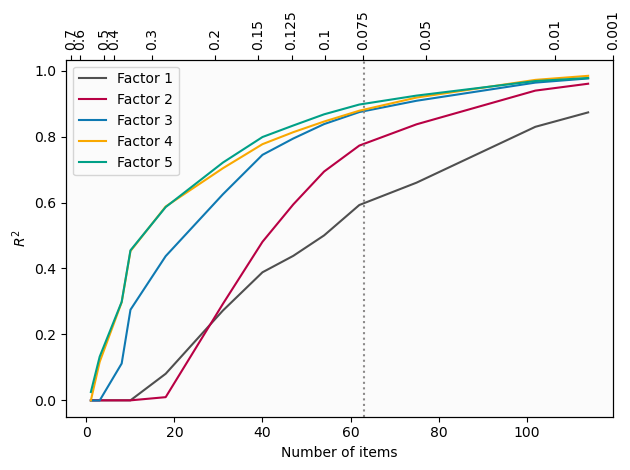

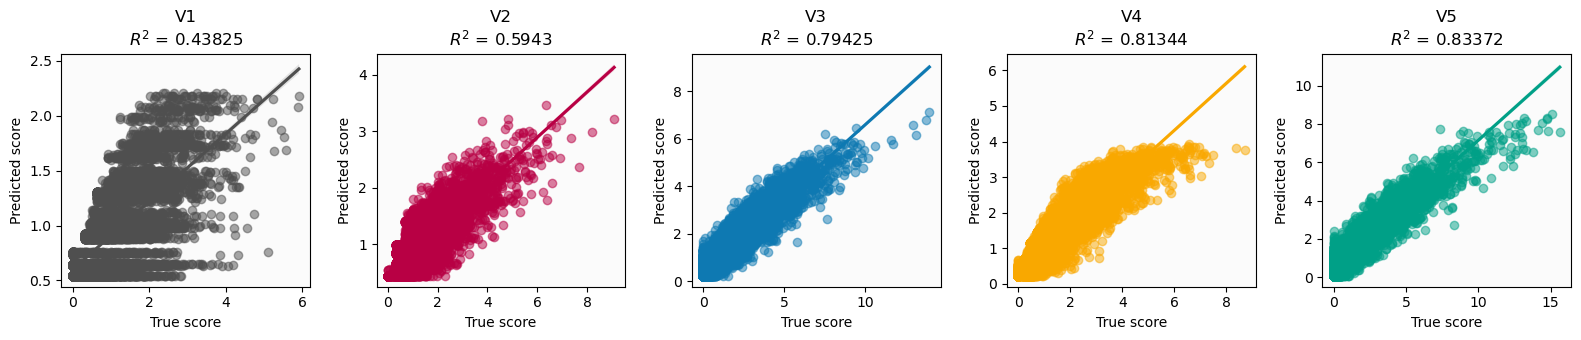

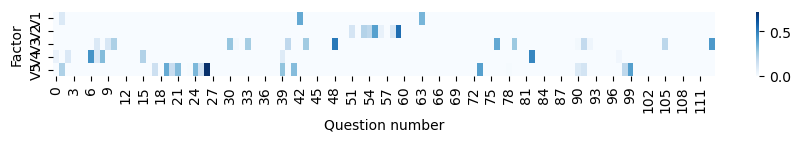

In [ ]:
from utils import LassoAnalysis

qns = X
scores = pd.read_csv(
    r"G:\ABCD\script\trail\trail_tsne_RF\factor analysis\output\NA\NMF_W.csv"
).iloc[:, 2:]

# Initialize the LassoAnalysis class
lasso_analysis = LassoAnalysis(qns, scores)

# Perform the analysis
lasso_analysis.perform_analysis()

# Plot R² values
lasso_analysis.plot_r2_values()

# Plot factor predictions
lasso_analysis.plot_factor_predictions(alpha=0.125)

# Plot heatmap of coefficients
lasso_analysis.plot_heatmap(alpha=0.125)

# To be continued: 

## From neuroimaging data to latent factors (to be continued)

In [ ]:
# load data and drop the first column and the subject id
data = pd.read_csv(r"G:/ABCD/data/mri_y_rsfmr_cor_gp_gp.csv")
# only keep eventname = baseline_year_1_arm_1
data = (
    data[data["eventname"] == "baseline_year_1_arm_1"]
    .drop(columns=["eventname"])
    .dropna()
)

labels = pd.read_csv(
    r"G:\ABCD\script\trail\trail_tsne_RF\factor analysis\output\NA\EFA.csv"
).iloc[:, 1:]
# labels = pd.read_csv(r'G:/ABCD/data/mh_p_cbcl.csv')
# # only keep the  column.('cbcl_scr_syn_anxdep_t')
# labels = labels[labels['eventname'] == 'baseline_year_1_arm_1'].drop(columns=['eventname'])
# labels = labels[['src_subject_id', 'cbcl_scr_syn_anxdep_t']].dropna()

# only keep the subjects that have labels
data = data[data["src_subject_id"].isin(labels["src_subject_id"])]
data = data.drop(columns=["src_subject_id"])
# reshaped_array = scores.iloc[:,1].to_numpy().reshape(-1, 1)

In [ ]:
data = pd.read_csv(r"G:/ABCD/data/mri_y_rsfmr_cor_gp_gp.csv")
data = (
    data[data["eventname"] == "baseline_year_1_arm_1"]
    .drop(columns=["eventname"])
    .dropna()
)

Spearman 相关性: 0.0345 (p=0.00145), MSE: 0.3762


c:\Anaconda\envs\mne\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Anaconda\envs\mne\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Anaconda\envs\mne\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Anaconda\envs\mne\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Anaconda\envs\mne\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21449 (\N{CJK UNIFIED IDEOGRAPH-53C9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Anacond

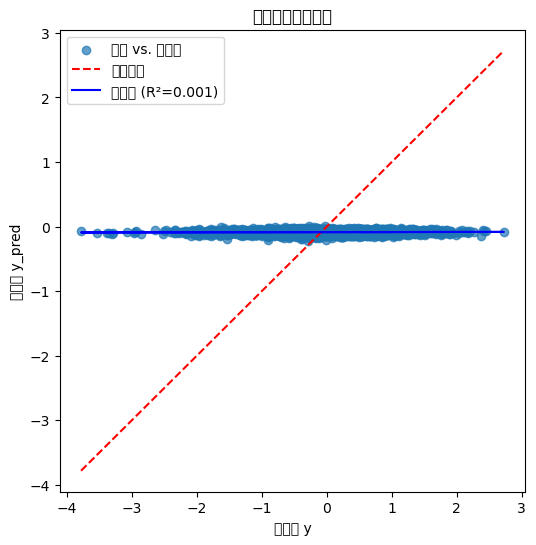

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, LeaveOneOut


# ========== 2. 交叉验证与预测 ==========
def cross_validate_prediction(
    X, y, cv_type="loocv", k_folds=10, feature_selection=False
):
    if cv_type == "loocv":
        cv = LeaveOneOut()
    elif cv_type == "kfold":
        cv = KFold(n_splits=k_folds, shuffle=True, random_state=9873)
    else:
        raise ValueError("cv_type 必须是 'loocv' 或 'kfold'")

    y_actual, y_pred = [], []

    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if feature_selection:
            feature_corr = np.array(
                [
                    (
                        stats.spearmanr(X_train[:, i], y_train)[0]
                        if len(np.unique(X_train[:, i])) > 1
                        else 0
                    )
                    for i in range(X_train.shape[1])
                ]
            )
            selected_features = np.where(np.abs(feature_corr) > 0.1)[0]
            if len(selected_features) == 0:
                selected_features = np.arange(X_train.shape[1])
            X_train, X_test = (
                X_train[:, selected_features],
                X_test[:, selected_features],
            )

        # model = LinearRegression()  # 或 Lasso(alpha=0.01)
        model = Lasso(alpha=0.01)
        model.fit(X_train, y_train)

        y_pred.extend(model.predict(X_test))
        y_actual.extend(y_test)

    return np.array(y_actual), np.array(y_pred)


# ========== 3. 计算评估指标 ==========
def evaluate_performance(y_actual, y_pred):
    spearman_corr, spearman_p = stats.spearmanr(y_actual, y_pred)
    mse = mean_squared_error(y_actual, y_pred)

    if np.isnan(spearman_corr):
        spearman_corr, spearman_p = 0, 1

    print(f"Spearman 相关性: {spearman_corr:.4f} (p={spearman_p:.5f}), MSE: {mse:.4f}")


# ========== 4. 画图（预测 vs 真实值） ==========
def plot_results(y_actual, y_pred):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_actual, y_pred, alpha=0.7, label="预测 vs. 真实值")
    plt.plot(
        [min(y_actual), max(y_actual)],
        [min(y_actual), max(y_actual)],
        "r--",
        label="理想情况",
    )

    model = LinearRegression()
    model.fit(y_actual.reshape(-1, 1), y_pred)
    y_fit = model.predict(y_actual.reshape(-1, 1))
    plt.plot(
        y_actual,
        y_fit,
        "b-",
        label=f"拟合线 (R²={model.score(y_actual.reshape(-1, 1), y_pred):.3f})",
    )

    plt.xlabel("真实值 y")
    plt.ylabel("预测值 y_pred")
    plt.title("交叉验证预测结果")
    plt.legend()
    plt.show()


# ========== 运行代码 ==========
if __name__ == "__main__":
    # 1. 读取数据
    X = np.array(data1)  # 转换为 numpy 数组，确保索引不影响
    y = latent_factors.iloc[:, 0].values  # 显式转换为 numpy 数组
    # y = factor_scores[:,0]
    # X = data1.loc[:, :].values  # 确保 data1 按列取所有值
    # y = latent_df.iloc[:, 0].reindex(data1.index).values  # 让 y 的索引与 data1 对齐
    scaler = StandardScaler()

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42
    )
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # 2. 进行交叉验证（LOOCV 或 KFold），选择是否启用特征选择
    cv_type = "loocv"  # 可改成 "kfold"
    feature_selection = True  # 是否开启特征选择

    y_actual, y_pred = cross_validate_prediction(
        X_train,
        y_train,
        cv_type=cv_type,
        k_folds=10,
        feature_selection=feature_selection,
    )

    # 3. 计算 Spearman 相关性 & 误差
    evaluate_performance(y_actual, y_pred)

    # 4. 画图
    plot_results(y_actual, y_pred)

Spearman 相关性: 0.0397 (p=0.00025), MSE: 0.8274


c:\Anaconda\envs\mne\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Anaconda\envs\mne\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Anaconda\envs\mne\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Anaconda\envs\mne\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Anaconda\envs\mne\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21449 (\N{CJK UNIFIED IDEOGRAPH-53C9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Anacond

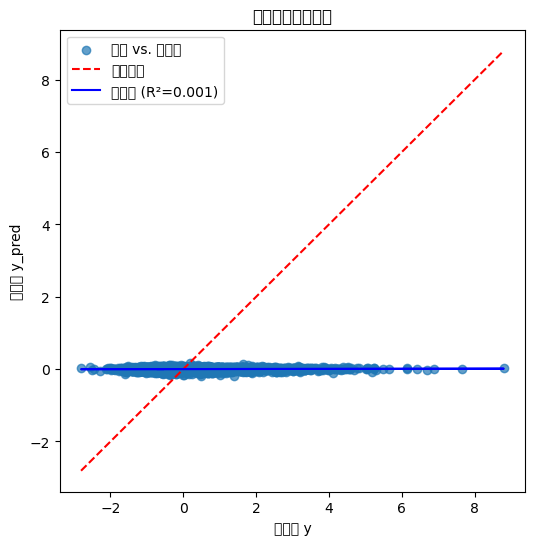

In [ ]:
# ========== 运行代码 ==========
if __name__ == "__main__":
    # 1. 读取数据
    X = np.array(data1)  # 转换为 numpy 数组，确保索引不影响
    # y = latent_df.iloc[:, 0].values  # 显式转换为 numpy 数组
    y = factor_scores[:, 0]
    # X = data1.loc[:, :].values  # 确保 data1 按列取所有值
    # y = latent_df.iloc[:, 0].reindex(data1.index).values  # 让 y 的索引与 data1 对齐
    scaler = StandardScaler()

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42
    )
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # 2. 进行交叉验证（LOOCV 或 KFold），选择是否启用特征选择
    cv_type = "loocv"  # 可改成 "kfold"
    feature_selection = True  # 是否开启特征选择

    y_actual, y_pred = cross_validate_prediction(
        X_train,
        y_train,
        cv_type=cv_type,
        k_folds=10,
        feature_selection=feature_selection,
    )

    # 3. 计算 Spearman 相关性 & 误差
    evaluate_performance(y_actual, y_pred)

    # 4. 画图
    plot_results(y_actual, y_pred)

# Getting fmri data

In [ ]:
import os

import cx_Oracle

# 手动指定 Instant Client 目录
os.environ["PATH"] = "C:\\oracle\\instantclient_23_7;" + os.environ["PATH"]

# 测试 cx_Oracle 是否正确加载
print(cx_Oracle.clientversion())

In [ ]:
# 连接数据库
dsn = cx_Oracle.makedsn(
    "mindarvpc.cqahbwk3l1mb.us-east-1.rds.amazonaws.com", 1521, service_name="ORCL"
)
conn = cx_Oracle.connect(user="k21116947_1236370", password="", dsn=dsn)

cursor = conn.cursor()

# 查询 ENDPOINT 列的前 10 条记录
query = """
SELECT ENDPOINT
FROM S3_LINKS
WHERE ENDPOINT LIKE '%baseline%' AND ENDPOINT LIKE '%rsfMRI%' AND ENDPOINT LIKE '%NDARINV005V6D2C%' AND ENDPOINT LIKE '%MPROC%' AND ENDPOINT LIKE '%release5%'
"""
cursor.execute(query)

s3_samples = [row[0] for row in cursor.fetchall()]

cursor.close()
conn.close()

print("S3_LINKS 表的 ENDPOINT 列数据示例：")
for url in s3_samples:
    print(url)

S3_LINKS 表的 ENDPOINT 列数据示例：
s3://NDAR_Central_4/submission_44835/abcd-mproc-release4/NDARINV005V6D2C_baselineYear1Arm1_ABCD-MPROC-rsfMRI_20180422111847.tgz
s3://NDAR_Central_4/submission_44835/abcd-mproc-release4/NDARINV005V6D2C_baselineYear1Arm1_ABCD-MPROC-rsfMRI_20180422103917.tgz
s3://NDAR_Central_3/submission_52682/abcd-mproc-release5/NDARINV005V6D2C_baselineYear1Arm1_ABCD-MPROC-rsfMRI_20180422103917.tgz
s3://NDAR_Central_4/submission_44835/abcd-mproc-release4/NDARINV005V6D2C_baselineYear1Arm1_ABCD-MPROC-rsfMRI_20180422111312.tgz
s3://NDAR_Central_3/submission_52682/abcd-mproc-release5/NDARINV005V6D2C_baselineYear1Arm1_ABCD-MPROC-rsfMRI_20180422111312.tgz
s3://NDAR_Central_4/submission_32739/NDARINV005V6D2C_baselineYear1Arm1_ABCD-MPROC-rsfMRI_20180422111312.tgz
s3://NDAR_Central_4/submission_44835/abcd-mproc-release4/NDARINV005V6D2C_baselineYear1Arm1_ABCD-MPROC-rsfMRI_20180422104516.tgz
s3://NDAR_Central_3/submission_52682/abcd-mproc-release5/NDARINV005V6D2C_baselineYear1Arm1_ABCD-

## complete pipeline

In [ ]:
dsn = cx_Oracle.makedsn(
    "mindarvpc.cqahbwk3l1mb.us-east-1.rds.amazonaws.com", 1521, service_name="ORCL"
)
conn = cx_Oracle.connect(user="k21116947_1236370", password="", dsn=dsn)

cursor = conn.cursor()

query = """
SELECT ENDPOINT
FROM S3_LINKS
WHERE ENDPOINT LIKE '%baseline%' AND ENDPOINT LIKE '%rsfMRI%' AND ENDPOINT LIKE '%NDARINV005V6D2C%' AND ENDPOINT LIKE '%MPROC%' 
"""
cursor.execute(query)

s3_samples = [row[0] for row in cursor.fetchall()]

cursor.close()
conn.close()

# for url in s3_samples:
#    print(url)

np.savetxt("output/s3_links.txt", s3_samples, fmt="%s")


!downloadcmd -dp 1236370 -t output/s3_links.txt -d ./